##**ENTRENAMIENTO DEL MODELO DE CORNERS TOTALES EN UN PARTIDO DE LIGAPRO**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#Carga del dataset
df = pd.read_csv('/content/ligaPro_corners_datos_prueba.csv')

###**CREACIÓN DE FEATURES**

In [ ]:
import pandas as pd

# Ordenamos por fecha para procesar cronológicamente
df = df.sort_values('fecha')

#Crear un feature basado en la diferencia de corners de los equipos en condición de local
df['diff_corners_local'] = (
    df.groupby('equipo_local_id')['corners_local']
      .diff()  # resta partido actual - partido anterior (solo dentro del mismo equipo local)
)

#Crear un feature basado en la diferencia de corners de los equipos en condición de visitante
df['diff_corners_visitante'] = (
    df.groupby('equipo_visitante_id')['corners_visitante']
      .diff()  # resta partido actual - partido anterior (solo dentro del mismo equipo visitante)
)

#Feature de rendimiento de los equipos cuando jugan de local y visitante (es una diferencia para ver como rinden tanto fuera como de local)
df['diff_corners_equipo'] = df.apply(
    lambda row: row['diff_corners_local'] if pd.notnull(row['diff_corners_local']) else row['diff_corners_visitante'],
    axis=1
)


In [ ]:
#Creación de features para los promedios de cada equipo cuando juegan de local y visita
#El promeido es de la cantidad de corners que realizan
df = df.sort_values(by='fecha').reset_index(drop=True)
# Promedio histórico acumulado como local
df['promedio_corners_local_hist'] = (
    df.groupby('equipo_local_id')['corners_local']
      .transform(lambda x: x.shift().expanding().mean().fillna(x))#En casos de los primeros partidos se rellena con la media y no con nan
)
# Promedio histórico acumulado como visitante
df['promedio_corners_visitante_hist'] = (
    df.groupby('equipo_visitante_id')['corners_visitante']
      .transform(lambda x: x.shift().expanding().mean().fillna(x))#En casos de los primeros partidos se rellena con la media y no con nan
)

In [ ]:
df.columns

Index(['fecha', 'estadio', 'local', 'visitante', 'score',
       'tarjetas_amarillas_local', 'tarjetas_amarillas_visitante',
       'tarjetas_rojas_local', 'tarjetas_rojas_visitante', 'posesion_local',
       'posesion_visitante', 'fuera_de_juego_local',
       'fuera_de_juego_visitante', 'corners_local', 'corners_visitante',
       'tiros_a_puerta_local', 'tiros_a_puerta_visitante', 'tiros_fuera_local',
       'tiros_fuera_visitante', 'intentos_a_porteria_local',
       'intentos_a_porteria_visitante', 'atajadas_local', 'atajadas_visitante',
       'faltas_local', 'faltas_visitante', 'penales_local',
       'penales_visitante', 'tiros_bloqueados_local',
       'tiros_bloqueados_visitante', 'ataques_peligrosos_local',
       'ataques_peligrosos_visitante', 'ataques_local', 'ataques_visitante',
       'faltas_totales', 'tarjetas_amarillas_totales',
       'tarjetas_rojas_totales', 'tarjetas_totales', 'tiros_esquina_totales',
       'avg_local_corners_local', 'avg_visitante_corners_visit

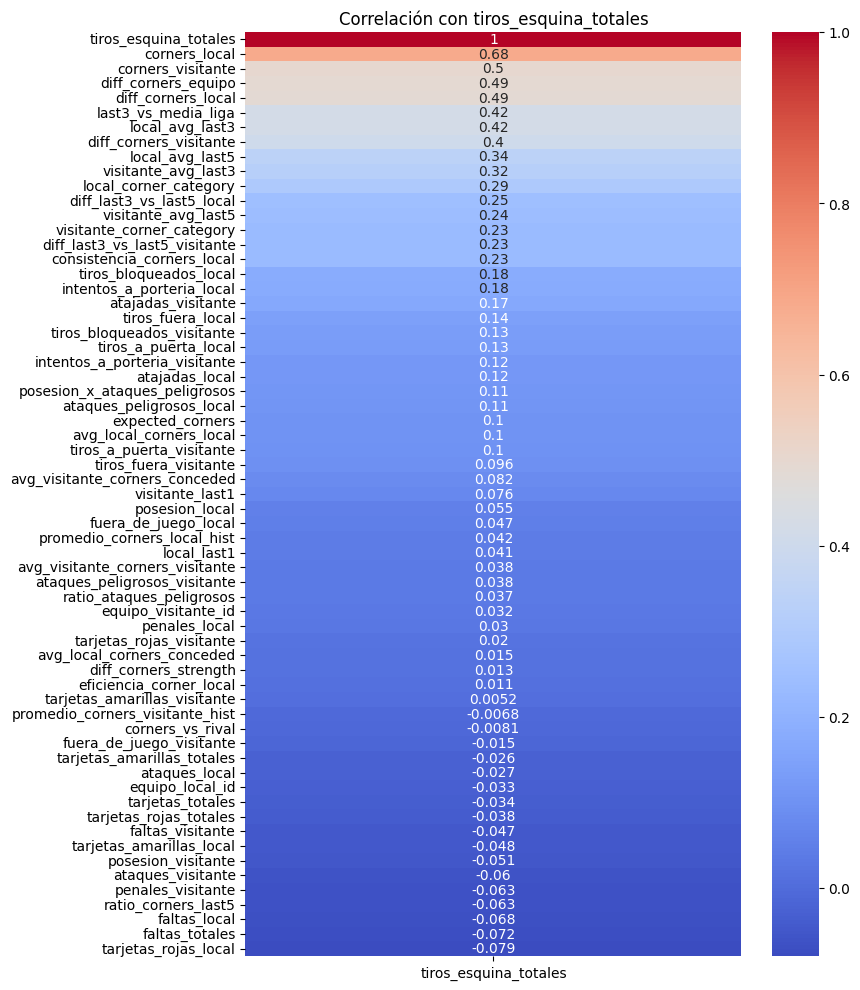

In [ ]:
# Momentaneamente se buscan como están las correlaciones de los features y nuestro objetivo que es los tiros de esquina totales
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_data = df[numeric_cols].corr()[['tiros_esquina_totales']].sort_values(by='tiros_esquina_totales', ascending=False)

# Graficar
plt.figure(figsize=(8, 12))
sns.heatmap(corr_data, annot=True, cmap='coolwarm')
plt.title('Correlación con tiros_esquina_totales')
plt.show()

**Nota:** No podemos tomar como features los corners de local y de visitante, dado que forman parte del target, y podría producir fuga de datos.

In [ ]:
#Adicional se buscará correlaciones con los métodos de Pearson para una correlación Lineal y de Spearman para correlaciones monótonas
# Calcular correlaciones con Pearson
correlaciones_pearson = (
    df.corr(numeric_only=True)['corners_local']
      .drop('tiros_esquina_totales')
      .sort_values(ascending=False)
)

# Calcular correlaciones con Spearman

correlaciones_spearman = (
    df.corr(method='spearman', numeric_only=True)['tiros_esquina_totales']
      .drop('tiros_esquina_totales')
      .sort_values(ascending=False)
)
#Veamos cuales son las más fuertes
print("🔹 Top 10 correlaciones Pearson:")
print(correlaciones_pearson.head(10))
print("\n🔹 Top 10 correlaciones Spearman:")
print(correlaciones_spearman.head(10))

🔹 Top 10 correlaciones Pearson:
corners_local                    1.000000
diff_corners_local               0.690527
diff_corners_equipo              0.684733
last3_vs_media_liga              0.613208
local_avg_last3                  0.613208
local_avg_last5                  0.497835
posesion_x_ataques_peligrosos    0.424692
local_corner_category            0.422345
ataques_peligrosos_local         0.408712
ratio_ataques_peligrosos         0.406918
Name: corners_local, dtype: float64

🔹 Top 10 correlaciones Spearman:
corners_local              0.654309
corners_visitante          0.475876
diff_corners_equipo        0.469966
diff_corners_local         0.467139
eficiencia_corner_local    0.436015
local_avg_last3            0.394168
last3_vs_media_liga        0.394168
diff_corners_visitante     0.393910
visitante_avg_last3        0.309667
local_avg_last5            0.306368
Name: tiros_esquina_totales, dtype: float64


In [ ]:
import pandas as pd

df = df.sort_values(by='fecha').reset_index(drop=True)
#Creación de feature basado en el promedio historico de corners realizados en condición de local
df['promedio_corners_local_hist'] = (
    df.groupby('equipo_local_id')['corners_local']
      .transform(lambda x: x.shift().expanding().mean().fillna(x))
)
#Creación de feature basado en el promedio historico de corners realizados en condición de visitante
df['promedio_corners_visitante_hist'] = (
    df.groupby('equipo_visitante_id')['corners_visitante']
      .transform(lambda x: x.shift().expanding().mean().fillna(x))
)

#Creación de feature basado en el promedio historico de corners
df['diff_promedio_corners'] = (
    df['promedio_corners_local_hist'] - df['promedio_corners_visitante_hist']
)

#Feature para ver el rendimiento a mitad de temporada
df['last3_pct_media_liga'] = df['local_avg_last3'] / df['last3_vs_media_liga']

#Feature para ver si entre más tenencia de balón más probabilidad de realizar tiros de esquina
df['presion_ofensiva_total'] = (
    (df['ataques_peligrosos_local'] + df['ataques_peligrosos_visitante']) *
    (df['posesion_local'] + df['posesion_visitante']) / 200
)

#Feature Relación tiros totales por ataque peligroso
df['ratio_tiros_por_ataque'] = (
    (df['tiros_a_puerta_local'] + df['tiros_a_puerta_visitante'] +
     df['tiros_fuera_local'] + df['tiros_fuera_visitante'] +
     df['tiros_bloqueados_local'] + df['tiros_bloqueados_visitante']) /
    (df['ataques_peligrosos_local'] + df['ataques_peligrosos_visitante'])
)

#Feature para ver un enfrentamiento directo y ver cuantos se producen en dicho enfrentamiento
df['corners_vs_rival_hist'] = (
    df.groupby(['equipo_local_id', 'equipo_visitante_id'])['tiros_esquina_totales']
      .transform(lambda x: x.shift().expanding().mean().fillna(x))
)

#Volvemos a calcular las correlaciones
correlaciones_pearson = (
    df.corr(numeric_only=True)['tiros_esquina_totales']
      .drop('tiros_esquina_totales')
      .sort_values(ascending=False)
)

correlaciones_spearman = (
    df.corr(method='spearman', numeric_only=True)['corners_local']
      .drop('tiros_esquina_totales')
      .sort_values(ascending=False)
)

print("🔹 Top 15 correlaciones Pearson:")
print(correlaciones_pearson.head(15))

print("\n🔹 Top 15 correlaciones Spearman:")
print(correlaciones_spearman.head(15))


🔹 Top 15 correlaciones Pearson:
corners_local                    0.681117
corners_visitante                0.498772
diff_corners_equipo              0.491320
corners_vs_rival_hist            0.490219
diff_corners_local               0.486421
last3_vs_media_liga              0.419581
local_avg_last3                  0.419581
diff_corners_visitante           0.404062
local_avg_last5                  0.338121
visitante_avg_last3              0.323646
local_corner_category            0.292292
diff_last3_vs_last5_local        0.247340
visitante_avg_last5              0.239688
visitante_corner_category        0.232481
diff_last3_vs_last5_visitante    0.231351
Name: tiros_esquina_totales, dtype: float64

🔹 Top 15 correlaciones Spearman:
corners_local                    1.000000
diff_corners_local               0.669823
diff_corners_equipo              0.663882
eficiencia_corner_local          0.640878
local_avg_last3                  0.586956
last3_vs_media_liga              0.586956
ratio_at

In [ ]:
#Calculamos un feature basado en la diferencia entre corners que realiza un local y visitante
df['diff_corners_local_visitante'] = df['corners_local'] - df['corners_visitante']
#Feature de ratio de corners delo local
df['ratio_corners_local'] = df['corners_local'] / (
    df['corners_local'] + df['corners_visitante'] + 1e-6
)
#Sacamos la media de corners que se realizaron en los partidos
df['mean_corners_partido'] = (df['corners_local'] + df['corners_visitante']) / 2
#Recalcular corners en situaciones de peligro
df['corners_por_ataque_peligroso'] = (
    df['corners_local'] + df['corners_visitante']
) / (df['ataques_peligrosos_local'] + df['ataques_peligrosos_visitante'] + 1e-6)

df['diff_ratio_corners'] = (
    (df['corners_local'] - df['corners_visitante']) /
    (df['corners_local'] + df['corners_visitante'] + 1e-6)
)

#Recalcular correlaciones
correlaciones_pearson = (
    df.corr(numeric_only=True)['tiros_esquina_totales']
      .drop('tiros_esquina_totales')
      .sort_values(ascending=False)
)

correlaciones_spearman = (
    df.corr(method='spearman', numeric_only=True)['tiros_esquina_totales']
      .drop('tiros_esquina_totales')
      .sort_values(ascending=False)
)

print("🔹 Top 15 correlaciones Pearson:")
print(correlaciones_pearson.head(15))

print("\n🔹 Top 15 correlaciones Spearman:")
print(correlaciones_spearman.head(15))

🔹 Top 15 correlaciones Pearson:
mean_corners_partido         1.000000
corners_local                0.681117
corners_visitante            0.498772
diff_corners_equipo          0.491320
corners_vs_rival_hist        0.490219
diff_corners_local           0.486421
last3_vs_media_liga          0.419581
local_avg_last3              0.419581
diff_corners_visitante       0.404062
local_avg_last5              0.338121
visitante_avg_last3          0.323646
local_corner_category        0.292292
diff_last3_vs_last5_local    0.247340
visitante_avg_last5          0.239688
visitante_corner_category    0.232481
Name: tiros_esquina_totales, dtype: float64

🔹 Top 15 correlaciones Spearman:
mean_corners_partido            1.000000
corners_por_ataque_peligroso    0.815923
corners_local                   0.654309
corners_visitante               0.475876
diff_corners_equipo             0.469966
diff_corners_local              0.467139
corners_vs_rival_hist           0.460029
eficiencia_corner_local         0

**NOTA 2:** Aunque no se crearon aqui en este notebook, columnas como local_avg_last3 son features que calculan el promedio de corners realizados por equipo en los últimos 3 partidos. Misma situación con last5 que son corners realizados en los últimos 5 partidos.  

###Procederemos a limpiar y generar un nuevo csv para ser más explícitos

In [ ]:
#Features con fuerte correlación que serán usadas para entrenar el modelo
columnas_seleccionadas = [
    'equipo_local_id', 'equipo_visitante_id', 'fecha',
    'corners_local', 'corners_visitante', 'corners_vs_rival_hist',
    'last3_vs_media_liga', 'local_avg_last3', 'local_avg_last5',
    'visitante_avg_last3', 'local_corner_category', 'diff_last3_vs_last5_local',
    'visitante_avg_last5', 'visitante_corner_category', 'diff_last3_vs_last5_visitante',
    'consistencia_corners_local', 'tiros_bloqueados_local', 'corners_por_ataque_peligroso','diff_corners_equipo','diff_corners_local','diff_corners_visitante',
    'tiros_esquina_totales'  #Variable objetivo
]

df_limpio = df[columnas_seleccionadas].copy()#Copiamos las columnas para formar el nuevo dataset

# Verificar que no haya valores NaN
print("Valores faltantes por columna:")
print(df_limpio.isnull().sum())

#rellenar NaN si existen, por ejemplo con la mediana de cada columna numérica
for col in df_limpio.select_dtypes(include='number').columns:
    df_limpio[col].fillna(df_limpio[col].median(), inplace=True)

print("\nDataset limpio listo:")
print(df_limpio.head())


Valores faltantes por columna:
equipo_local_id                   0
equipo_visitante_id               0
fecha                             0
corners_local                     0
corners_visitante                 0
corners_vs_rival_hist             0
last3_vs_media_liga               0
local_avg_last3                   0
local_avg_last5                   0
visitante_avg_last3               0
local_corner_category             0
diff_last3_vs_last5_local         0
visitante_avg_last5               0
visitante_corner_category         0
diff_last3_vs_last5_visitante     0
consistencia_corners_local        0
tiros_bloqueados_local            0
corners_por_ataque_peligroso      0
diff_corners_equipo              10
diff_corners_local               23
diff_corners_visitante           23
tiros_esquina_totales             0
dtype: int64

Dataset limpio listo:
   equipo_local_id  equipo_visitante_id       fecha  corners_local  \
0                1                    5  2020-08-16              7   
1

/tmp/ipython-input-3264107481.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_limpio[col].fillna(df_limpio[col].median(), inplace=True)


Modelo usado:

Se eligió el modelo de XBGRRegressor por su robustez frente a datos faltantes y a valores atípicos o Outliers, dado que si se eliminaban más registros era posible que el modelo le cueste más aprender mejores patrones, además que se podían eliminar algunso enfrentamientos. Adicional XGBRregressor tiende a reducir el riesgo a un posible sobreajusto o Overfiting a comparación a otros modelos como Linearegression, svm entre otros.

In [1]:
#Librerías a usar
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
df_descargar = df_limpio.copy()
df_descargar.to_csv('df_limpio_prueba.csv', index=False)

In [ ]:
#Eliminar columnas que no deben entrar, dado que pueden provocar fuga de datos
cols_eliminar = ['corners_local', 'corners_visitante']
df_limpio = df_limpio.drop(columns=[col for col in cols_eliminar if col in df_limpio.columns])

#Definimos X y Y
X = df_limpio.drop(columns=['tiros_esquina_totales', 'fecha'])
y = df_limpio['tiros_esquina_totales']

#Divisón del conjunto de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
#Escalar los datos para mejorar el rendimiento
no_escalar = ['equipo_local_id', 'equipo_visitante_id']#Columnas que no se debene escalar
columnas_a_escalar = [col for col in X.columns if col not in no_escalar]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[columnas_a_escalar] = scaler.fit_transform(X_train[columnas_a_escalar])

X_test_scaled = X_test.copy()
X_test_scaled[columnas_a_escalar] = scaler.transform(X_test[columnas_a_escalar])


In [ ]:
#Definir modelo base
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
#GridSearch para encontrar mejores parámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,                   #Aplicación de validaciónn cruzada con número de folds 5
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1]},
             scoring='r2', verbose=1)

In [ ]:
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor R2 promedio CV:", grid_search.best_score_)

Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Mejor R2 promedio CV: 0.7950991630554199


In [ ]:
# Entrenar modelo final
final_model = XGBRegressor(
    **grid_search.best_params_,
    objective='reg:squarederror',
    random_state=42
)

#Usamor fit para el entrenamiento final
final_model.fit(X_train_scaled, y_train)

y_test_pred = final_model.predict(X_test_scaled)

In [ ]:
#Evaluamos el modelo usando el R2 score y tambien el Raíz del Error Cuadrático Medio
y_test_pred = final_model.predict(X_test_scaled)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print(f"RMSE test: {rmse_test:.3f}")
print(f"R2 test: {r2_test:.3f}")

RMSE test: 1.648
R2 test: 0.743


Ese error nos indica que nuestro modelo puede llegar a equivocarse entre 1.6 +- corners que para una predicción o armar una combinada en una casa de apuestas es relativamente correcto.

Nuestro R2 Score nos indica también que el modelo es capaz de explicar el 74% de las variaciones dentro de los corners totales posibles en un partido.

In [ ]:
#Guardar modelo
import joblib
joblib.dump(final_model, 'prediccion_corners_totales.pkl')

#Escalador necesario para hacer predicciones posteriormente

joblib.dump(scaler, 'escalador_corners.pkl')

['escalador_corners.pkl']

In [ ]:
df_descargar.columns

Index(['equipo_local_id', 'equipo_visitante_id', 'fecha', 'corners_local',
       'corners_visitante', 'corners_vs_rival_hist', 'last3_vs_media_liga',
       'local_avg_last3', 'local_avg_last5', 'visitante_avg_last3',
       'local_corner_category', 'diff_last3_vs_last5_local',
       'visitante_avg_last5', 'visitante_corner_category',
       'diff_last3_vs_last5_visitante', 'consistencia_corners_local',
       'tiros_bloqueados_local', 'corners_por_ataque_peligroso',
       'diff_corners_equipo', 'diff_corners_local', 'diff_corners_visitante',
       'tiros_esquina_totales'],
      dtype='object')

In [ ]:
#Features que necesita el modelo para las predicciones de corners
columnas_modelo = X_train_scaled.columns.tolist()
print(columnas_modelo)

['equipo_local_id', 'equipo_visitante_id', 'corners_vs_rival_hist', 'last3_vs_media_liga', 'local_avg_last3', 'local_avg_last5', 'visitante_avg_last3', 'local_corner_category', 'diff_last3_vs_last5_local', 'visitante_avg_last5', 'visitante_corner_category', 'diff_last3_vs_last5_visitante', 'consistencia_corners_local', 'tiros_bloqueados_local', 'corners_por_ataque_peligroso', 'diff_corners_equipo', 'diff_corners_local', 'diff_corners_visitante']


In [ ]:
#Descargar los datos que se necesitan para las predicciones adicionando la columna fecha
df_limpio.columns

Index(['equipo_local_id', 'equipo_visitante_id', 'fecha',
       'corners_vs_rival_hist', 'last3_vs_media_liga', 'local_avg_last3',
       'local_avg_last5', 'visitante_avg_last3', 'local_corner_category',
       'diff_last3_vs_last5_local', 'visitante_avg_last5',
       'visitante_corner_category', 'diff_last3_vs_last5_visitante',
       'consistencia_corners_local', 'tiros_bloqueados_local',
       'corners_por_ataque_peligroso', 'diff_corners_equipo',
       'diff_corners_local', 'diff_corners_visitante',
       'tiros_esquina_totales'],
      dtype='object')

In [ ]:
df_predicciones = df_limpio.drop(columns=['tiros_esquina_totales'])

In [ ]:
df_predicciones.columns

Index(['equipo_local_id', 'equipo_visitante_id', 'fecha',
       'corners_vs_rival_hist', 'last3_vs_media_liga', 'local_avg_last3',
       'local_avg_last5', 'visitante_avg_last3', 'local_corner_category',
       'diff_last3_vs_last5_local', 'visitante_avg_last5',
       'visitante_corner_category', 'diff_last3_vs_last5_visitante',
       'consistencia_corners_local', 'tiros_bloqueados_local',
       'corners_por_ataque_peligroso', 'diff_corners_equipo',
       'diff_corners_local', 'diff_corners_visitante'],
      dtype='object')

In [ ]:
df_predicciones.to_csv('dataset_corners_listo.csv',index=False)